# import libraries

In [26]:
import numpy as np 
import matplotlib.pyplot as plt
from glob import glob
import cv2
import pandas as pd

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import os
import seaborn as sns
from keras.applications import DenseNet169

In [2]:
SIZE = [224,224]
train_images = []
train_labels  = []

# Load Data

In [3]:
for directory_path in glob("/dataset_address/*"):
    labels = directory_path.split("\\")[-1]
    for image_path in glob(os.path.join(directory_path,"*.png"))+ glob(os.path.join(directory_path,"*.jp*g")):
        image = cv2.imread(image_path,cv2.IMREAD_COLOR)
        image = cv2.resize(image,SIZE)
        image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
        train_images.append(image)
        train_labels.append(labels)

In [4]:
images = np.array(train_images)
labels = np.array(train_labels)


# Label formating

In [5]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
labels = label.fit_transform(labels)
labels.shape

(1125,)

In [6]:
images = images/255.0

# Build the model

In [18]:
DenseNet169 = DenseNet169(input_shape = SIZE + [3],weights='imagenet',include_top=False,pooling='avg')

for layer in vgg.layers:
    layer.trainable = False
vgg.summary()

Model: "densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

# Feature extraction

In [19]:
features = DenseNet169.predict(images)
features = features.reshape(features.shape[0],-1)

# Feature selection(ANOVA)

In [27]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
def select_features(X_train, y_train, X_test,i):
    # configure to select all features
    fs = SelectKBest(score_func=f_classif, k=i)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs



# Classification, Accuracy, Sensitivity, Specifity, precision, and f1-score

In [28]:
from sklearn.metrics import f1_score
import statistics
from sklearn.metrics import confusion_matrix,accuracy_score
from xgboost import XGBClassifier
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split


x_train,x_test,y_train,y_test = train_test_split(features,labels,test_size=0.2)
x_train,x_test = select_features(x_train,y_train,x_test,275)
classifier = XGBClassifier()
classifier.fit(x_train,y_train)
yhat = classifier.predict(x_test)
acc = accuracy_score(y_test, yhat)
print(confusion_matrix(y_test, yhat))
Y_test = y_test
Y_pred = yhat
l = confusion_matrix(Y_test, Y_pred)

print(f"\nAccuracy score : ", accuracy_score(Y_test, Y_pred))
print(f"\nconfusion matrix : \n", confusion_matrix(Y_test, Y_pred))
print(f"\nf1 score : ", f1_score(Y_test, Y_pred, average="macro"))
print(f"\nprecision score : ", precision_score(Y_test, Y_pred, average="macro"))
print(f"\nSpecifity : ", (l[1,1]+l[2,2]) / (l[1,1]+l[2,2]+l[1,0]+l[2,0]))
print(f"\nSensitivity : ", l[0,0] / (l[0,0] + l[0,1]+l[0,2]))
print(f"\n============")

C:\Users\Ali\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:40:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[ 23   1   2]
 [  0 100   6]
 [  0   9  84]]

Accuracy score :  0.92

confusion matrix : 
 [[ 23   1   2]
 [  0 100   6]
 [  0   9  84]]

f1 score :  0.9242698480793718

precision score :  0.9407114624505929

Specifity :  1.0

Sensitivity :  0.8846153846153846



# Exporting Confusion Matrix in SVG

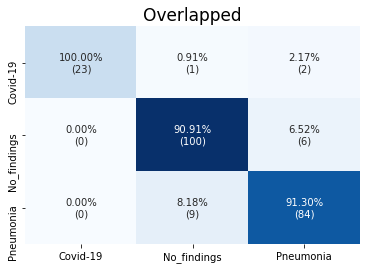

<Figure size 432x288 with 0 Axes>

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

class_names=['Covid-19','No_findings','Pneumonia']
group_count = ['{0:0.0f}'.format(value) for value in
                l.flatten()]
group_counts=[]
group_percentages = []
for i in group_count:
    group_counts.append(f'({i})')
for i in range(0,3):
    for j in range(0,3):
        group_percentages.append(l[i,j]/np.sum(l[:,j]))
        
group_percentages = ['{0:.2%}'.format(value) for value in
            group_percentages]

labels = [f'{v2}\n{v3}' for  v2, v3 in
          zip(group_percentages,group_counts)]                     

labels = np.asarray(labels).reshape(3,3)                    

df_cm = pd.DataFrame(l, index = [i for i in class_names],
                  columns = [i for i in class_names])
plt.figure(figsize = (6,4))
ax = plt.axes()
sns = sn.heatmap(df_cm, annot=labels,ax = ax,cbar=False,fmt="",cmap="Blues")
ax.set_title('Overlapped',fontsize = 17)
plt.show()
figure = sns.get_figure()    
figure.savefig(f'Overlapped.svg')
plt.clf()  

# plt.savefig(f'saving-a-seaborn-plot-as-eps-file-overlapped.png')